In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
import time
import numpy as np
import pandas as pd
import torch
from torch import nn
import pyranges
import cooler
from cooltools.lib.numutils import adaptive_coarsegrain
import matplotlib.pyplot as plt

from selene_utils3 import MemmapGenome, Genomic2DFeatures
from orca_modules_1kb import Encoder2_1kb, Decoder, Encoder

In [3]:
WORK = "/archive/bioinformatics/Zhou_lab/shared/yczhang/orca"
genome = MemmapGenome(
        input_path=f"{WORK}/microc_orca_restricted/dm6/dm6.fa",
        memmapfile=f"{WORK}/microc_orca_restricted/dm6/dm6.fa.mmap",
    )

smooth_diag_NC14 = np.load(
        f"{WORK}/microc_orca_restricted/NC14_125bp_madmaxiter0_diag0_expected.tsv.npy"
    )
normmat_NC14 = np.exp(
    smooth_diag_NC14[np.abs(np.arange(2000)[:, None] - np.arange(2000)[None, :])]
)
eps_NC14 = np.min(normmat_NC14)
c_NC14 = cooler.Cooler(f"{WORK}/microc_orca_restricted/NC14_125bp_madmaxiter0.mcool::/resolutions/125")

smooth_diag_NC12 = np.load(
        f"{WORK}/microc_orca_restricted/NC12_125bp_madmaxiter0_diag0_expected.tsv.npy"
    )
normmat_NC12 = np.exp(
    smooth_diag_NC12[np.abs(np.arange(2000)[:, None] - np.arange(2000)[None, :])]
)
eps_NC12 = np.min(normmat_NC12)
c_NC12 = cooler.Cooler(f"{WORK}/microc_orca_restricted/NC12_125bp_madmaxiter0.mcool::/resolutions/125")

In [62]:
res = 125
sequence_length = 250000
mat_size = sequence_length // res
modelstr = "NC12_res125.MP.woCentro.1kb.v2.con.lr05" # "NC12_res125.MP.woCentro.1kb.v2.con.lr05" NC14_res125.MP.woCentro.1kb.v2.con.con

net0 = nn.DataParallel(Encoder())
net = nn.DataParallel(Encoder2_1kb())

denet_1 = nn.DataParallel(Decoder())
denet_2 = nn.DataParallel(Decoder())
denet_4 = nn.DataParallel(Decoder())
denet_8 = nn.DataParallel(Decoder())


net0.load_state_dict(torch.load("./checkpoints/model_" + modelstr + ".net0.checkpoint"))
net.load_state_dict(torch.load("./checkpoints/model_" + modelstr + ".checkpoint"))
denet_1.load_state_dict(torch.load("./checkpoints/model_" + modelstr + ".d1.checkpoint"))
denet_2.load_state_dict(torch.load("./checkpoints/model_" + modelstr + ".d2.checkpoint"))
denet_4.load_state_dict(torch.load("./checkpoints/model_" + modelstr + ".d4.checkpoint"))
denet_8.load_state_dict(torch.load("./checkpoints/model_" + modelstr + ".d8.checkpoint"))

net0.cuda()
net.cuda()
denet_1.cuda()
denet_2.cuda()
denet_4.cuda()
denet_8.cuda()

net0.eval()
net.eval()
denet_1.eval()
denet_2.eval()
denet_4.eval()
denet_8.eval()

smooth_diag = np.load(
        f"{WORK}/microc_orca_restricted/NC12_125bp_madmaxiter0_diag0_expected.tsv.npy" # NC14_125bp_madmaxiter0_diag0_expected.tsv.npy" # NC12_125bp_madmaxiter0_diag0_expected.tsv.npy
    )
normmat = np.exp(
    smooth_diag[np.abs(np.arange(8000)[:, None] - np.arange(8000)[None, :])]
)

genome = MemmapGenome(
        input_path=f"{WORK}/microc_orca_restricted/dm6/dm6.fa",
        memmapfile=f"{WORK}/microc_orca_restricted/dm6/dm6.fa.mmap",
    )

normmat_r1 = np.reshape(normmat[:250, :250], (250, 1, 250, 1)).mean(axis=1).mean(axis=2)
normmat_r2 = np.reshape(normmat[:500, :500], (250, 2, 250, 2)).mean(axis=1).mean(axis=2)
normmat_r4 = np.reshape(normmat[:1000, :1000], (250, 4, 250, 4)).mean(axis=1).mean(axis=2)
normmat_r8 = np.reshape(normmat[:2000, :2000], (250, 8, 250, 8)).mean(axis=1).mean(axis=2)
normmat_r16 = (
        np.reshape(normmat[:4000, :4000], (250, 16, 250, 16)).mean(axis=1).mean(axis=2)
    )
normmat_r32 = (
        np.reshape(normmat[:8000, :8000], (250, 32, 250, 32)).mean(axis=1).mean(axis=2)
    )
eps1 = np.min(normmat_r1)
eps2 = np.min(normmat_r2)
eps4 = np.min(normmat_r4)
eps8 = np.min(normmat_r8)
eps16 = np.min(normmat_r16)
eps32 = np.min(normmat_r32)

normmats = {
    1: normmat_r1,
    2: normmat_r2,
    4: normmat_r4,
    8: normmat_r8,
    16: normmat_r16,
    32: normmat_r32,
}
epss = {1: eps1, 2: eps2, 4: eps4, 8: eps8, 16: eps16, 32: eps32}
denets = {
    1: denet_1,
    2: denet_2,
    4: denet_4,
    8: denet_8,
    # 16: denet_16,
    # 32: denet_32,
}

def pred_1kb(seq):

    with torch.no_grad():
        encoding0 = net0(seq)
        encoding1, encoding2, encoding4, encoding8 = net(encoding0)
        encodings = {
            1: encoding1,
            2: encoding2,
            4: encoding4,
            8: encoding8,
            # 16: encoding16,
            # 32: encoding32,
        }
        level = 8
        start = 0
        distenc = torch.log(
            torch.FloatTensor(normmats[level][None, None, :, :]).cuda()
        ).expand(seq.shape[0], 1, 250, 250)

        pred = denets[level].forward(
                encodings[level][:, :, int(start / level) : int(start / level) + 250],
                distenc
            )

        del encodings
        del encoding1
        del encoding2
        del encoding4
        del encoding8

    return pred

def pred_125(seq, depth=3):

    with torch.no_grad():
        encoding0 = net0(seq)
        encoding1, encoding2, encoding4, encoding8 = net(encoding0)
        encodings = {
            1: encoding1,
            2: encoding2,
            4: encoding4,
            8: encoding8,
            # 16: encoding16,
            # 32: encoding32,
        }
        level = 8
        start = 0
        distenc = torch.log(
            torch.FloatTensor(normmats[level][None, None, :, :]).cuda()
        ).expand(seq.shape[0], 1, 250, 250)

        pred = denets[level].forward(
                encodings[level][:, :, int(start / level) : int(start / level) + 250],
                distenc
            )
        for level in [4, 2, 1][:depth]:
            r = 63
            start = start + r * level * 2
            distenc = torch.log(
                        torch.FloatTensor(normmats[level][None, None, :, :]).cuda()
                    ).expand(sequence.shape[0], 1, 250, 250)
            pred = denets[level].forward(
                            encodings[level][
                                :, :, int(start / level) : int(start / level) + 250
                            ],
                            distenc,
                            pred[:, :, r : r + 125, r : r + 125].detach(),
                        )

        del encodings
        del encoding1
        del encoding2
        del encoding4
        del encoding8

    return pred

In [5]:
chromosome_dict = pd.DataFrame({
    'chromosome': ['chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrX', 'chrY'],
    'chromosome_start': [0, 6000000, 0, 4100000, 0, 0, 0],
    'chromosome_end': [22000000, 25200000, 23000000, 32000000, 1300000, 21500000, 3600000]
})

In [8]:
(19017578+19051456)/2

19034517.0

In [63]:
segment_length = 250000
chromosome = 'chrX'
segment_start = 19034517 - segment_length // 2
segment_end = segment_start + segment_length
sequence = genome.get_encoding_from_coords(chromosome, segment_start, segment_end)[None, ...]
with torch.no_grad():
    pred = pred_125(torch.FloatTensor(sequence).transpose(1,2).cuda(), depth=2).detach().cpu().numpy()

In [43]:
19034517 - segment_length // 2, 19034517 + segment_length // 2

(18909517, 19159517)

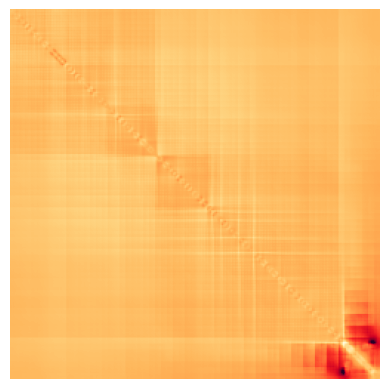

In [80]:
from colormaps import hnh_cmap_ext5
hnh_cmap_ext5.set_bad(color='white')

plt.imshow(pred[0,0], cmap=hnh_cmap_ext5, vmax=3)
plt.axis('off')
plt.savefig('NC12_pred250_chrX_19017578-19051456.pdf')

In [ ]:
level8 start:0 end:250000
level4 start:63000 end:188000
level2 start:94500 end:157000
level1 start:110250 end:141500

In [52]:
start_1k = 19034517 - segment_length // 2 - 517
start_125 = start_1k + 110250
end_125 = start_1k + 141500
start_250 = start_1k + 94500
end_250 = start_1k + 157000

In [81]:
start_250, end_250

(19003500, 19066000)

In [55]:
mat_NC14_bal.shape

(500, 500)

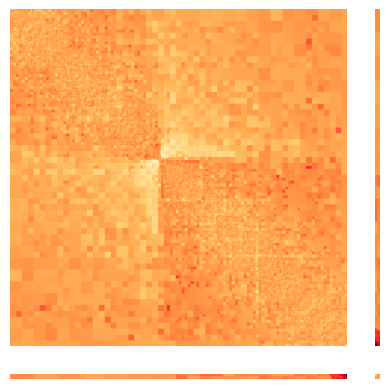

In [61]:
test_pos = f"chrX:{start_250}-{end_250}"

mat_NC14_bal = c_NC14.matrix(balance=True).fetch(test_pos)
mat_NC14_unbal = c_NC14.matrix(balance=False).fetch(test_pos)
mat_NC14_cg = adaptive_coarsegrain(mat_NC14_bal, mat_NC14_unbal, max_levels=8, cutoff=5)
mat_NC14_cg = mat_NC14_cg.reshape(250, 2, 250, 2).mean(axis=-1).mean(axis=-2)
mat_NC14_log = np.log((mat_NC14_cg + eps2) / (normmat_r2 + eps2))

plt.imshow(mat_NC14_log, cmap=hnh_cmap_ext5)
plt.axis('off')
plt.savefig('NC14_250bp_chrX_19017578-19051456.pdf')

In [70]:
np.nanmax(mat_NC12_log)

4.08560868535357

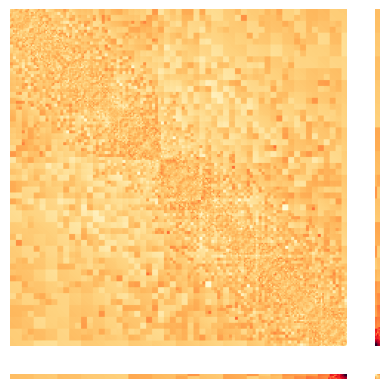

In [74]:
test_pos = f"chrX:{start_250}-{end_250}"

mat_NC12_bal = c_NC12.matrix(balance=True).fetch(test_pos)
mat_NC12_unbal = c_NC12.matrix(balance=False).fetch(test_pos)
mat_NC12_cg = adaptive_coarsegrain(mat_NC12_bal, mat_NC12_unbal, max_levels=8, cutoff=5)
mat_NC12_cg = mat_NC12_cg.reshape(250, 2, 250, 2).mean(axis=-1).mean(axis=-2)
mat_NC12_log = np.log((mat_NC12_cg + eps2) / (normmat_r2 + eps2))

plt.imshow(mat_NC12_log, cmap=hnh_cmap_ext5, vmax=3)
plt.axis('off')
plt.savefig('NC12_250bp_chrX_19017578-19051456.pdf')

In [28]:
segment_length = 250000
chromosome = 'chrX'
segment_start = 19034517 - segment_length // 2
segment_end = segment_start + segment_length
sequence = genome.get_encoding_from_coords(chromosome, segment_start, segment_end)[None, ...]
with torch.no_grad():
    pred = pred_1kb(torch.FloatTensor(sequence).transpose(1,2).cuda()).detach().cpu().numpy()

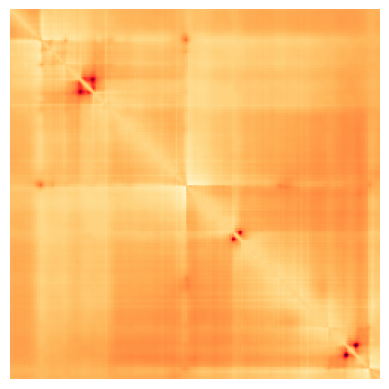

In [29]:
from colormaps import hnh_cmap_ext5
hnh_cmap_ext5.set_bad(color='white')

plt.imshow(pred[0,0], cmap=hnh_cmap_ext5)
plt.axis('off')
plt.savefig('NC14_pred1k_chrX_19017578-19051456.pdf')

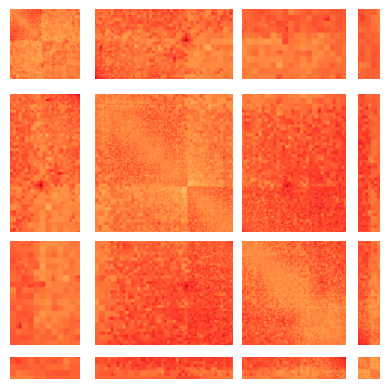

In [30]:
test_pos = f"chrX:{segment_start-517}-{segment_start+segment_length-517}"

mat_NC14_bal = c_NC14.matrix(balance=True).fetch(test_pos)
mat_NC14_unbal = c_NC14.matrix(balance=False).fetch(test_pos)
mat_NC14_cg = adaptive_coarsegrain(mat_NC14_bal, mat_NC14_unbal, max_levels=8, cutoff=5)
mat_NC14_log = np.log((mat_NC14_cg + eps_NC14) / (normmat_NC14 + eps_NC14))

plt.imshow(mat_NC14_log, cmap=hnh_cmap_ext5)
plt.axis('off')
plt.savefig('NC14_1k_chrX_19017578-19051456.pdf')

In [37]:
segment_length = 250000
chromosome = 'chrX'
segment_start = 19034517 - segment_length // 2
segment_end = segment_start + segment_length
sequence = genome.get_encoding_from_coords(chromosome, segment_start, segment_end)[None, ...]
with torch.no_grad():
    pred = pred_1kb(torch.FloatTensor(sequence).transpose(1,2).cuda()).detach().cpu().numpy()

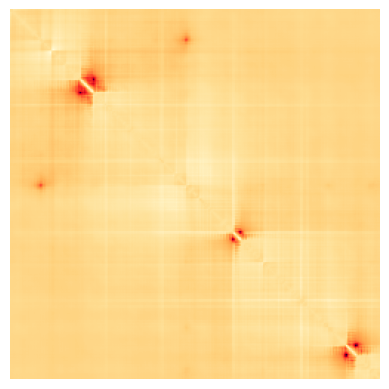

In [41]:
from colormaps import hnh_cmap_ext5
hnh_cmap_ext5.set_bad(color='white')

plt.imshow(pred[0,0], cmap=hnh_cmap_ext5)
plt.axis('off')
plt.savefig('NC12_pred1k_chrX_19017578-19051456.pdf')

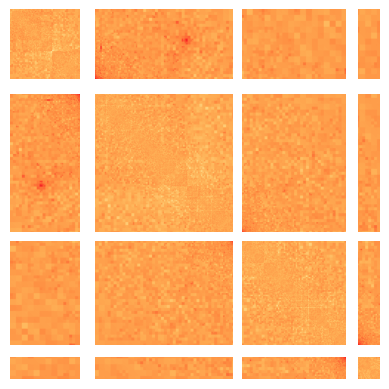

In [40]:
test_pos = f"chrX:{segment_start-517}-{segment_start+segment_length-517}"

mat_NC12_bal = c_NC12.matrix(balance=True).fetch(test_pos)
mat_NC12_unbal = c_NC12.matrix(balance=False).fetch(test_pos)
mat_NC12_cg = adaptive_coarsegrain(mat_NC12_bal, mat_NC12_unbal, max_levels=8, cutoff=5)
mat_NC12_log = np.log((mat_NC12_cg + eps_NC12) / (normmat_NC12 + eps_NC12))

plt.imshow(mat_NC12_log, cmap=hnh_cmap_ext5)
plt.axis('off')
plt.savefig('NC12_1k_chrX_19017578-19051456.pdf')